# Recursive Matrix Multiplication
### Set values for whether you would like to generate new results or just use the JSON that has previously been generated

In [1]:
# Set to true if you want to run the tests again. Otherwise just loads results from JSON
GENERATE_NEW_RESULTS = False

# Set to true if you want to save figures to disk. Change path as needed
SAVE_FIGURES_TO_DISK = False
FIG_SAVE_PATH = "../../thesis/figures/matmul/"

Load in packages and set options for prettier plots

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import concurrent.futures
import json

from helper_funcs import save_fig, make_cache, MORTON, ROW_ARR, BLOCK_ARR

from data_structures.morton_order import MortonOrder
from data_structures.block_array import BlockArray
from data_structures.row_major_array import RowMajorArray

from algorithms.matmul import matmul_rec

In [3]:
matplotlib.rcParams['figure.figsize'] = (9.0, 4.8)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## Defining functions/variables to run tests

In [4]:
def results_for_arr_and_tile_size(vals):
    n, tile_size = vals
    r = int(np.log2(n)) - int(np.log2(tile_size))
    if r < 0:
        return None, tile_size

    print(f"{n} -- {tile_size}")
    
    cs1 = make_cache()
    cs2 = make_cache()
    cs3 = make_cache()

    rnd_vals1 = np.random.rand(n, n)
    rnd_vals2 = np.random.rand(n, n)

    morton1 = MortonOrder(rnd_vals1, cache=cs1)
    morton2 = MortonOrder(rnd_vals2, cache=cs1, offset=morton1.get_next_offset())
    
    block_arr1 = BlockArray(rnd_vals1, cache=cs2)
    block_arr2 = BlockArray(rnd_vals2, cache=cs2, offset=block_arr1.get_next_offset())

    row_arr1 = RowMajorArray(rnd_vals1, cache=cs3)
    row_arr2 = RowMajorArray(rnd_vals2, cache=cs3, offset=row_arr1.get_next_offset())

    # Warm up
    matmul_rec(morton1, morton2, r)
    matmul_rec(block_arr1, block_arr2, r)
    matmul_rec(row_arr1, row_arr2, r)

    # Reset caches
    cs1.force_write_back()
    cs1.reset_stats()
    cs2.force_write_back()
    cs2.reset_stats()
    cs3.force_write_back()
    cs3.reset_stats()

    # Do actual test
    matmul_rec(morton1, morton2, r)
    matmul_rec(block_arr1, block_arr2, r)
    matmul_rec(row_arr1, row_arr2, r)
    
    # Save results
    obj = {
        MORTON: list(cs1.stats()),
        BLOCK_ARR: list(cs2.stats()),
        ROW_ARR: list(cs3.stats())
    }

    print(f"{n} -- {tile_size} finished")
    return obj, tile_size
    

def results_for_arr_size(n):
    print(n)
    vals = [(n, tile_size) for tile_size in tile_sizes]    
    obj = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (res, tile_size) in executor.map(results_for_arr_and_tile_size, vals):
            if res is not None:
                obj[tile_size] = res
    return obj, n

In [5]:
ns = [2**i for i in range(5, 10)]
tile_sizes = [2**i for i in range(2, 10)]

print("ns:", ns)
print("ts:", tile_sizes)

ns: [32, 64, 128, 256, 512]
ts: [4, 8, 16, 32, 64, 128, 256, 512]


## Generating/loading in test results

In [6]:
if GENERATE_NEW_RESULTS:
    results = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (obj, n) in executor.map(results_for_arr_size, ns):
            results[n] = obj
            
    with open('results/matrix-result.json', 'w') as f:
        json.dump(results, f, indent=4)


with open('results/matrix-result.json', 'r') as f:
    results = json.load(f)

## Plotting

In [7]:
def get_val_arr(n, typ=MORTON, cache_level=0, stat="HIT_count"):    
    res_arr = []
    n = str(n)
    for tile_size in results[n]:
        val_morton = results[n][tile_size][typ][cache_level][stat]
        val_arr = results[n][tile_size][ROW_ARR][cache_level][stat]
        res_arr.append(
            np.nan if val_arr == 0 else float(val_morton) / float(val_arr)
        )
    return res_arr

In [8]:
def make_plot(cache_level=0, stat="HIT_count"):
    labels = tile_sizes
    n32 = get_val_arr(32, stat=stat)
    n64 = get_val_arr(64, stat=stat)
    n128 = get_val_arr(128, stat=stat)
    n256 = get_val_arr(256, stat=stat)
    n512 = get_val_arr(512, stat=stat)

    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x[:len(n32)] - 2*width, n32, width, label='$n=32$')
    ax.bar(x[:len(n64)] - 1*width, n64, width, label='$n=64$')
    ax.bar(x[:len(n128)] + 0*width, n128, width, label='$n=128$')
    ax.bar(x[:len(n256)] + 1*width, n256, width, label='$n=256$')
    ax.bar(x[:len(n512)] + 2*width, n512, width, label='$n=512$')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    stat_simple_label = stat.lower().replace("_", " ")
    ax.set_ylabel(f'Relative {stat_simple_label}')
    ax.set_xlabel('Tile size')
    #ax.set_title(f'Relative {stat} of Morton Order vs. RowMajorArray')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc=4)

    fig.tight_layout()

    save_fig(f"relative-{stat}-matrix-l{cache_level + 1}.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)

    plt.show()

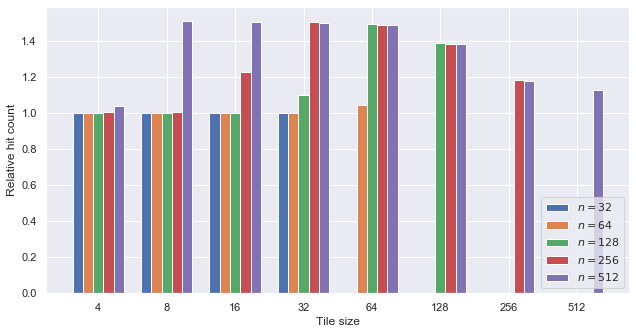

In [9]:
make_plot()

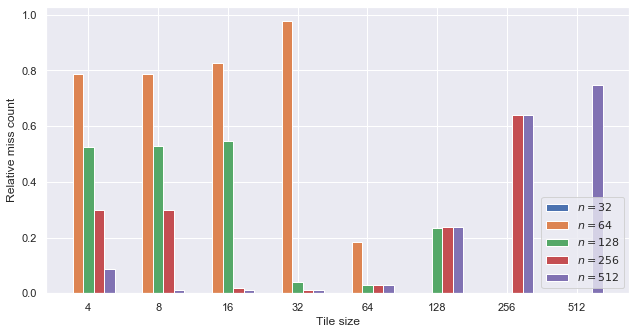

In [10]:
make_plot(stat="MISS_count")

## Sanity check:
On an intuitive level, the plots might seem baffling at first. These numbers should help explain why there is such a big discrepancy between the two plots

In [11]:
def print_some_stats(n, tile_size):
    n, tile_size = str(n), str(tile_size)
    print("Morton hit: ", results[n][tile_size][MORTON][0]["HIT_count"])
    print("RowArr hit: ", results[n][tile_size][ROW_ARR][0]["HIT_count"])
    print("Morton miss:", results[n][tile_size][MORTON][0]["MISS_count"])
    print("RowArr miss:", results[n][tile_size][ROW_ARR][0]["MISS_count"])
    
print_some_stats(512, 4)

Morton hit:  401235968
RowArr hit:  386244608
Morton miss: 1417216
RowArr miss: 16408576


In [12]:
n, tile_size = 512, 64
print_some_stats(n, tile_size)

Morton hit:  398524928
RowArr hit:  267624448
Morton miss: 4128256
RowArr miss: 135028736


## Cache hits and misses
Use `tile_size` of 4 (index `0`) in the following numbers

In [13]:
print(ns)
for typ in [MORTON, BLOCK_ARR]:
    print(typ)
    for stat in ["HIT_count", "MISS_count"]:
        vals = [get_val_arr(n, typ, stat=stat)[0] for n in ns]
        vals_str = ' & '.join([f"{val:.2f}" for val in vals])
        print(f"{stat:10}: {vals_str}")
    print()

[32, 64, 128, 256, 512]
morton
HIT_count : 1.00 & 1.00 & 1.00 & 1.01 & 1.04
MISS_count: nan & 0.79 & 0.53 & 0.30 & 0.09

block_arr
HIT_count : 1.00 & 1.00 & 1.00 & 1.01 & 1.04
MISS_count: nan & 1.00 & 0.67 & 0.38 & 0.11



## Cache hit-to-miss ratio
Use `tile_size` of 4 (index `0`) in the following numbers

In [14]:
def get_arr(n, typ=MORTON, cache_level=0, stat="HIT_count"):
    n = str(n)
    return np.array([ results[n][tile_size][typ][cache_level][stat] for tile_size in results[n] ])[0]

print(f"{'':12}{ns}")
for typ in [MORTON, BLOCK_ARR, ROW_ARR]:
    hits = np.array([get_arr(n, typ, stat="HIT_count") for n in ns])
    misses = np.array([get_arr(n, typ, stat="MISS_count") for n in ns])
    hit_to_miss = hits / misses
    vals_str = ' & '.join([f"{val:.2f}" for val in hit_to_miss])
    print(f"{typ:10}: {vals_str}")

            [32, 64, 128, 256, 512]
morton    : inf & 283.12 & 283.12 & 283.12 & 283.12
block_arr : inf & 222.29 & 222.29 & 222.29 & 222.29
row_arr   : inf & 222.29 & 148.28 & 83.82 & 23.54


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
